In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

c:\Users\Fred\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)



In [4]:

model = AlexNet()
model = model.to(device)


In [5]:

img_list = os.listdir('data_doors/closed/')
img_list.extend(os.listdir('data_doors/open/'))
# img_list.extend(os.listdir('data/semi/'))


In [6]:

print("Images: ", len(img_list))


Images:  2085


In [7]:

!rm -rf 'data/.ipynb_checkpoints/'

transform = transforms.Compose([
          transforms.Resize((64,64)),
          transforms.ToTensor()
          ])

batch_size = 64

doors_data = datasets.ImageFolder('data_doors', transform=transform)

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
curtin_data = datasets.ImageFolder('curtin_video', transform=transform)

In [9]:

print(doors_data.classes)
print(len(doors_data))

print(curtin_data.classes)
print(len(curtin_data))


['Closed', 'Open']
2085
['Closed', 'Open']
7


In [10]:

train_set, test_set = torch.utils.data.random_split(doors_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

print(train_data_size)
print(test_data_size)


1563
522


In [11]:
test_set = curtin_data + test_set
test_data_size = len(test_set)

In [12]:

trainLoader = torch.utils.data.DataLoader(train_set,batch_size=64, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)


In [13]:

new_testLoader = torch.utils.data.DataLoader(curtin_data, batch_size=7, shuffle=True)

In [14]:

print(train_data_size)
print(test_data_size)


1563
529


In [21]:

optimizer = optim.Adam(model.parameters(), lr=0.0001) #learning rate 1e-4
criterion = nn.CrossEntropyLoss()

epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')


Epoch: 0 | Train Loss: 0.345866425037384
Epoch: 1 | Train Loss: 0.34818315744400025
Epoch: 2 | Train Loss: 0.3587787675857544
Epoch: 3 | Train Loss: 0.33858797669410706
Epoch: 4 | Train Loss: 0.3377127432823181
Epoch: 5 | Train Loss: 0.34548160195350647
Epoch: 6 | Train Loss: 0.35047882437705996
Epoch: 7 | Train Loss: 0.3470883572101593
Epoch: 8 | Train Loss: 0.3760339820384979
Epoch: 9 | Train Loss: 0.3399857234954834


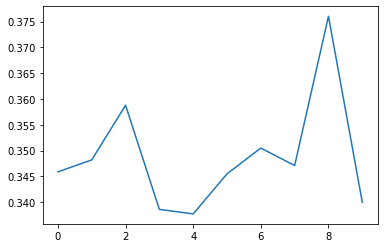

In [22]:

plt.plot(train_loss)


In [23]:

testiter = iter(new_testLoader)
images, labels = testiter.next()

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = doors_data.classes
print(labels)


tensor([0, 0, 0, 0, 0, 0, 1], device='cuda:0')


In [24]:
len(testiter)


1

0
1
2
3
4
5
6


<Figure size 1080x504 with 0 Axes>

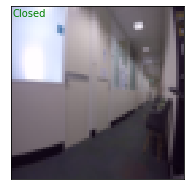

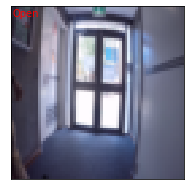

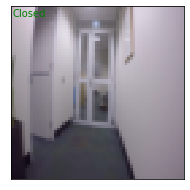

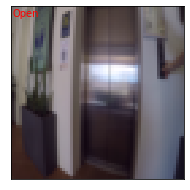

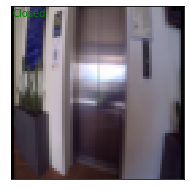

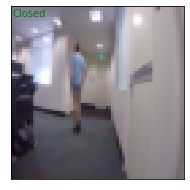

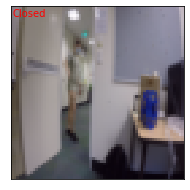

In [25]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
false_value = 0
num_images_disp = 7

for i in range(num_images_disp):
    print(i)
    # ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    # ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    fig2 = plt.figure(figsize=(15, 7))
    ax1 = fig2.add_subplot(2,1,1, xticks=[], yticks=[])
    ax1.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]: #if the label matches the maximum probability of the model
        # ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='green')
        ax1.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='green')
    else:
        # ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')
        ax1.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')
        #counter for false reading of doorway
        false_value = false_value + 1



In [26]:
print(false_value/num_images_disp)

0.42857142857142855
